<a href="https://colab.research.google.com/github/wahabtlais/disease_detection/blob/main/disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports & Setup**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import os

data_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# **Data Exploration**

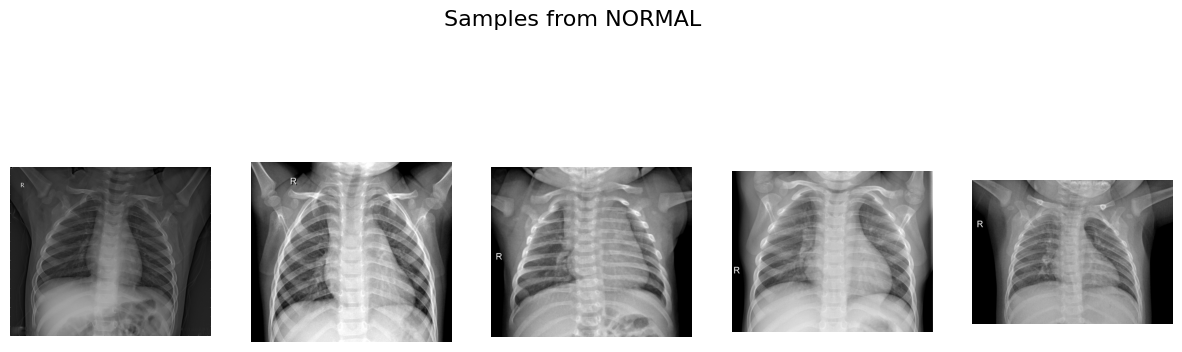

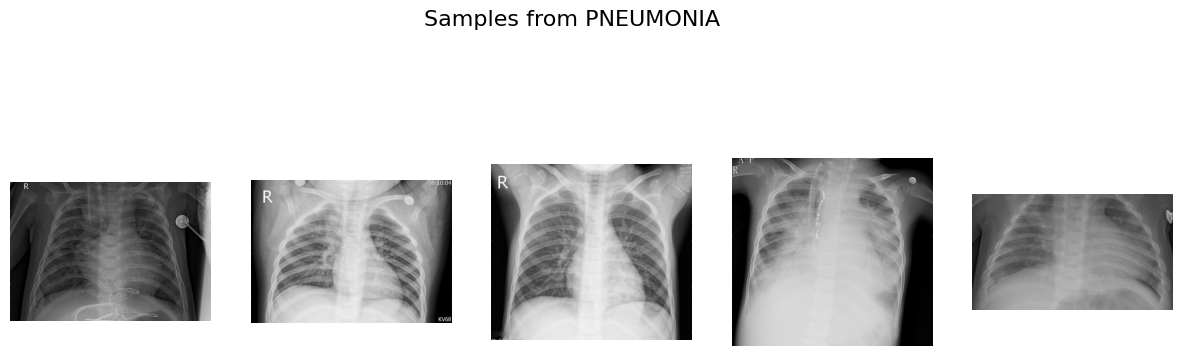

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# show some sample images for each class
def show_samples(folder, label):
  files = os.listdir(os.path.join(folder, label))
  fig, axes = plt.subplots(1, 5, figsize=(15, 5))
  for i in range(5):
    img_path = os.path.join(folder, label, files[i])
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap="gray")
    axes[i].axis('off')
  plt.suptitle(f"Samples from {label}", fontsize=16)
  plt.show()

show_samples(train_dir, "NORMAL")
show_samples(train_dir, "PNEUMONIA")

# **Data Preprocessing & Augmentation**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation and test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size= BATCH_SIZE,
    class_mode="binary",
    seed=SEED
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Model Building (Transfer Learning)**

##### Use MobileNetV2 (pretrained on ImageNet) as a feature extractor, then fine-tune

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

*(None, ...)* stands for batch size, which is left flexible, so that the model can accept any batch size at runtime

*Non-trainable params: 2,257,984 (8.61 MB)* are the pretrained MobileNetV2 layers so that they are frozen, meaning that their weights are not updated during training.

# **Training**

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), # to prevent overfitting and save training time
    # If training is interrupted, we can reload the saved model later.
    ModelCheckpoint("best_model.h5", save_best_only=True) # 'best_model.h5' is the filename where the model saves the weights. '.h5' is the HDF5 format.
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.6485 - loss: 0.6589

163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 877ms/step - accuracy: 0.6489 - loss: 0.6585 - val_accuracy: 0.5625 - val_loss: 0.5698
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7649 - loss: 0.4860

163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 667ms/step - accuracy: 0.7651 - loss: 0.4858 - val_accuracy: 0.8125 - val_loss: 0.4709
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8032 - loss: 0.4139

163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 654ms/step - accuracy: 0.8033 - loss: 0.4138 - val_accuracy: 0.8125 - val_loss: 0.4259
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.8466 - loss: 0.3416

163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 666ms/step - accuracy: 0.8466 - loss: 0.3416 - val_accuracy: 0.8125 - val_loss: 0.3893
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.8694 - loss: 0.2949 - val_accuracy: 0.8125 - val_loss: 0.3954


# **Evaluation**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.5874 - loss: 0.6555
Test Accuracy: 0.78
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.43      0.59       234
   PNEUMONIA       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



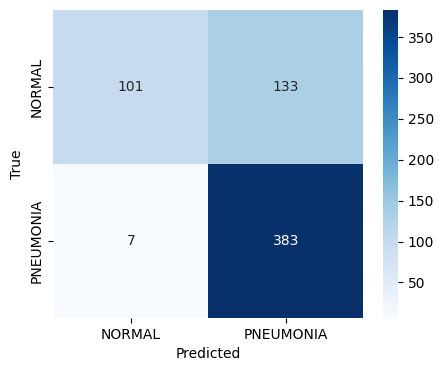

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

*law recall for NORMAL (0.43)*: needs fine-tuning

# **Fine-Tune the model**

In [26]:
from tensorflow.keras.models import load_model


model = load_model("best_model.h5")


# Unfreeze the last fe layers of MobileNetV2
for layer in model.layers:
  layer.trainable = False



# Unfreeze the last 50 layers
for layer in model.layers[-10:]:
  layer.trainable = True

# Compile with a smaller learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

class_weight = {0: 2.0, 1: 1.0}

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

checkpoint = ModelCheckpoint('fine_tuned_model.h5', monitor='val_loss', save_best_only=True)

In [27]:
# Fine-tune
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=callbacks,
    class_weight=class_weight
)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 700ms/step - accuracy: 0.8512 - loss: 0.4295 - val_accuracy: 0.8125 - val_loss: 0.3906
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9053 - loss: 0.2897

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9053 - loss: 0.2896 - val_accuracy: 0.7500 - val_loss: 0.3850
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9254 - loss: 0.2409

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9254 - loss: 0.2409 - val_accuracy: 0.6875 - val_loss: 0.3783


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.7046 - loss: 0.5921
Test Accuracy: 0.83
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



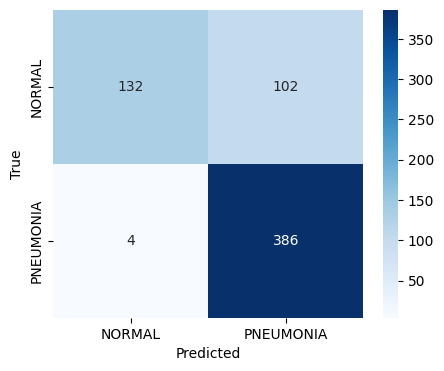

In [28]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **Model Interpretation (Grad-CAM)**

Using last conv layer:  None
Using last conv layer:  None
Using last conv layer:  None
Using last conv layer:  None


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


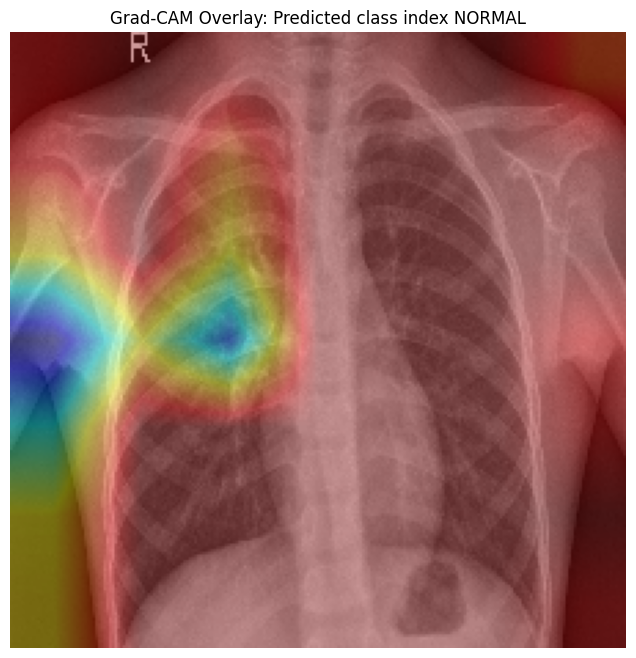

In [40]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

class_labels = ["NORMAL", "PNEUMONIA"]

# Select sample image
sample_img, label = test_gen[0][0][0], test_gen[0][1][0] # first image from the first batch
img_array = np.expand_dims(sample_img, axis=0)

# Identify the last convolutional layer
last_conv_layer_name = None
for layer in reversed(model.layers):
  if "conv" in layer.name.lower():
    last_conv_layer_name = layer.name
    break
  print("Using last conv layer: ", last_conv_layer_name)


grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

# Compute gradient of the top predicted class
with tf.GradientTape() as tape:
  conv_outputs, preds = grad_model(img_array)
  pred_index = tf.argmax(preds[0])
  class_channel = preds[:, pred_index]


grads = tape.gradient(class_channel, conv_outputs)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in feature map by the pooled gradient
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

heatmap = cv2.resize(heatmap.numpy(), (IMG_SIZE[1], IMG_SIZE[0]))

# Overlay heatmap on original image
img = (sample_img * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(8,8))
plt.imshow(overlay_img)
plt.axis('off')
plt.title(f"Grad-CAM Overlay: Predicted class index {class_labels[pred_index]}")
plt.show()